<a href="https://colab.research.google.com/github/Jitendra1907/Learngit/blob/main/1_TITANIC_SURVIVAL_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TITANIC SURVIVAL PREDICTION**







Introduction
Overview of the Titanic dataset
The Titanic dataset is a famous dataset in machine learning and data analysis, containing data on the passengers aboard the Titanic and their survival status. It consists of a training dataset with 891 observations and a test dataset with 418 observations. The goal is to predict the survival of passengers in the test dataset based on the variables in the training dataset.

Import libraries
To begin, let's import the necessary libraries that we'll be using throughout this notebook:

In [92]:
# Importing standard libraries
import os
import re
import warnings

# Importing related third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler

Getting the Data

In [93]:

ds = pd.read_csv('/content/tested.csv')
ds.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Understanding the Variables
Before we can begin analyzing the Titanic dataset, it's important to understand what each variable represents. The dataset contains the following variables:

PassengerId: A unique identifier for each passenger.

Survived: Whether or not the passenger survived (0 = No, 1 = Yes).

Pclass: The passenger class (1 = 1st class, 2 = 2nd class, 3 = 3rd class).

Name: The name of the passenger.

Sex: The gender of the passenger.

Age: The age of the passenger in years. Fractional values are included for infants.

SibSp: The number of siblings/spouses aboard the Titanic.

Parch: The number of parents/children aboard the Titanic.

Ticket: The ticket number for the passenger.

Fare: The fare paid by the passenger.

Cabin: The cabin number for the passenger (if available).

Embarked: The port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).


Data Exploration/Analysis

In [94]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [95]:
ds.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,0.363636,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.481622,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,0.000000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,0.000000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,1.000000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,1.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Above we can see that 36% out of the training-set survived the Titanic. On top of that we can already detect some features, that contain missing values, like the ‘Age’ feature.

In [96]:
ds.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,0,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,1,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,0,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S


In [97]:
ds.tail(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
398,1290,0,3,"Larsson-Rondberg, Mr. Edvard A",male,22.0,0,0,347065,7.7750,NaN,S
399,1291,0,3,"Conlon, Mr. Thomas Henry",male,31.0,0,0,21332,7.7333,NaN,Q
400,1292,1,1,"Bonnell, Miss. Caroline",female,30.0,0,0,36928,164.8667,C7,S
401,1293,0,2,"Gale, Mr. Harry",male,38.0,1,0,28664,21.0000,NaN,S
402,1294,1,1,"Gibson, Miss. Dorothy Winifred",female,22.0,0,1,112378,59.4000,NaN,C
403,1295,0,1,"Carrau, Mr. Jose Pedro",male,17.0,0,0,113059,47.1000,NaN,S
404,1296,0,1,"Frauenthal, Mr. Isaac Gerald",male,43.0,1,0,17765,27.7208,D40,C
405,1297,0,2,"Nourney, Mr. Alfred (Baron von Drachstedt"")""",male,20.0,0,0,SC/PARIS 2166,13.8625,D38,C
406,1298,0,2,"Ware, Mr. William Jeffery",male,23.0,1,0,28666,10.5000,NaN,S
407,1299,0,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5000,C80,C


In [98]:
def identify_missing_values(data):
    """Performs missing values computation."""
    # Verifying the presence of missing values
    miss_vals_num = data.isnull().sum()[data.isnull().sum() > 0]
    if miss_vals_num.empty:
        print("No missing values found.")
        return

    # Creating a table with numbers of missing values
    cols = {"missing_count": miss_vals_num.values}
    nans_df = pd.DataFrame(data=cols, index=miss_vals_num.index).sort_values(
        by="missing_count", ascending=False
    )

    # Adding shares of missing values
    nans_df["missing_fraction"] = nans_df["missing_count"] / data.shape[0]
    nans_df["missing_fraction"] = nans_df["missing_fraction"].round(4)

    # Adding data types
    nans_df["dtype"] = data[nans_df.index].dtypes
    nans_df = nans_df[["dtype", "missing_count", "missing_fraction"]]

    return nans_df
# Computing the number and share of

In [99]:
test_data=ds

Test data overview

In [100]:
# Displaying the summary of the data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [101]:
identify_missing_values(data=ds)

,dtype,missing_count,missing_fraction
Cabin,object,327,0.7823
Age,float64,86,0.2057
Fare,float64,1,0.0024




Exploratory data analysis

In [102]:
# Setting the style for plots
sns.set_theme(style="darkgrid")

In [103]:
training_data=test_data

Training data

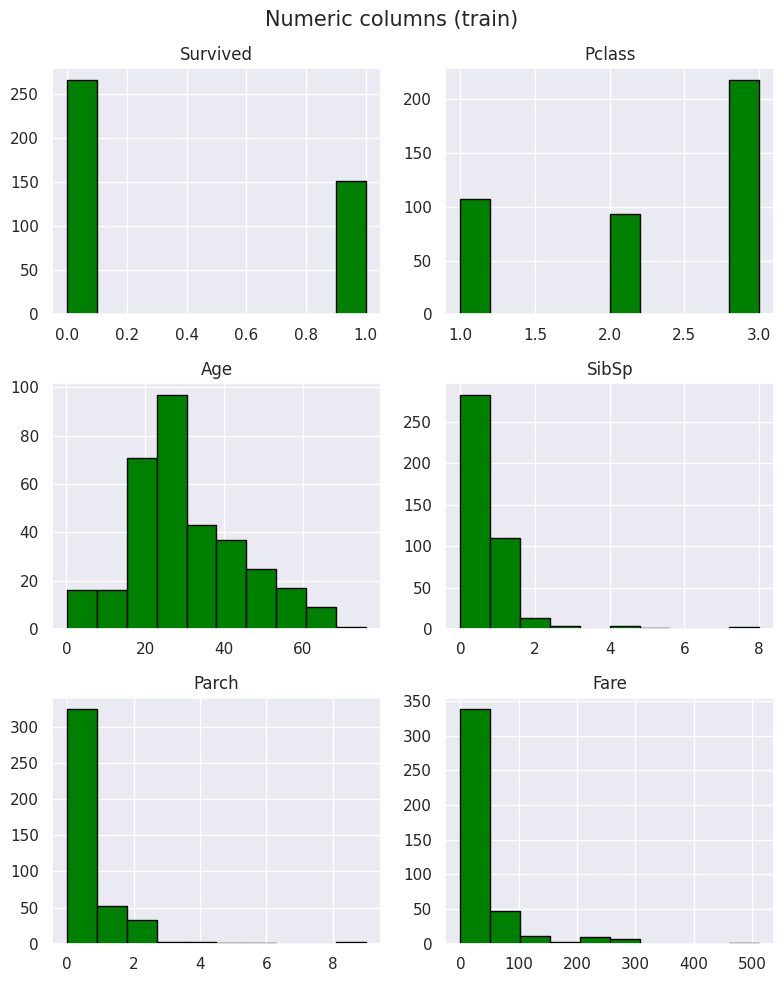

In [104]:
# Plotting histograms for the training data
cols_to_display = training_data.columns[1:]
training_data[cols_to_display].hist(
    figsize=(8, 10), color="green", edgecolor="black")
plt.suptitle("Numeric columns (train)", fontsize=15)
plt.tight_layout()
plt.show()

In [105]:
# Computing descriptive statistics
training_data.describe().round(2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,418.00,418.00,418.00,332.00,418.00,418.00,417.00
mean,1100.50,0.36,2.27,30.27,0.45,0.39,35.63
std,120.81,0.48,0.84,14.18,0.90,0.98,55.91
min,892.00,0.00,1.00,0.17,0.00,0.00,0.00
25%,996.25,0.00,1.00,21.00,0.00,0.00,7.90
50%,1100.50,0.00,3.00,27.00,0.00,0.00,14.45
75%,1204.75,1.00,3.00,39.00,1.00,0.00,31.50
max,1309.00,1.00,3.00,76.00,8.00,9.00,512.33


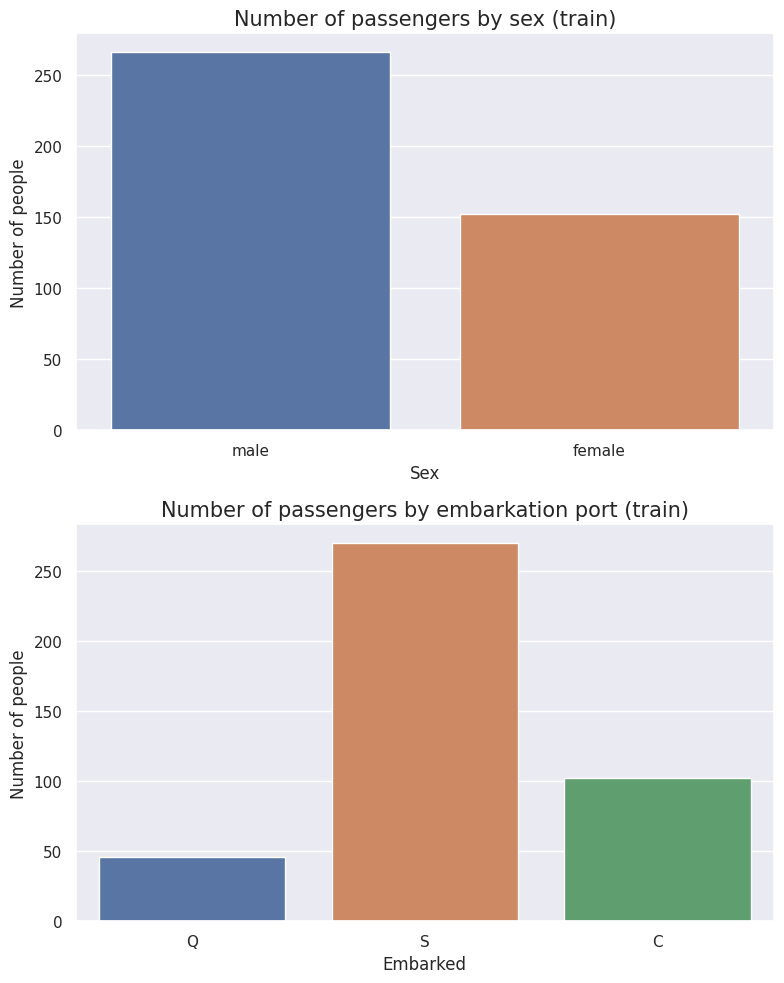

In [106]:
# Plotting barplots for categorical columns (training set)
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Plotting number of passengers by sex
num_pass_sex = sns.countplot(data=training_data, x="Sex", ax=axes[0])
axes[0].set_title("Number of passengers by sex (train)", fontsize=15)
axes[0].set_ylabel("Number of people")

# Plotting number of passengers by embarkation port
num_pass_embarked = sns.countplot(data=training_data, x="Embarked", ax=axes[1])
axes[1].set_title(
    "Number of passengers by embarkation port (train)", fontsize=15
)
axes[1].set_ylabel("Number of people")

plt.tight_layout()
plt.show()

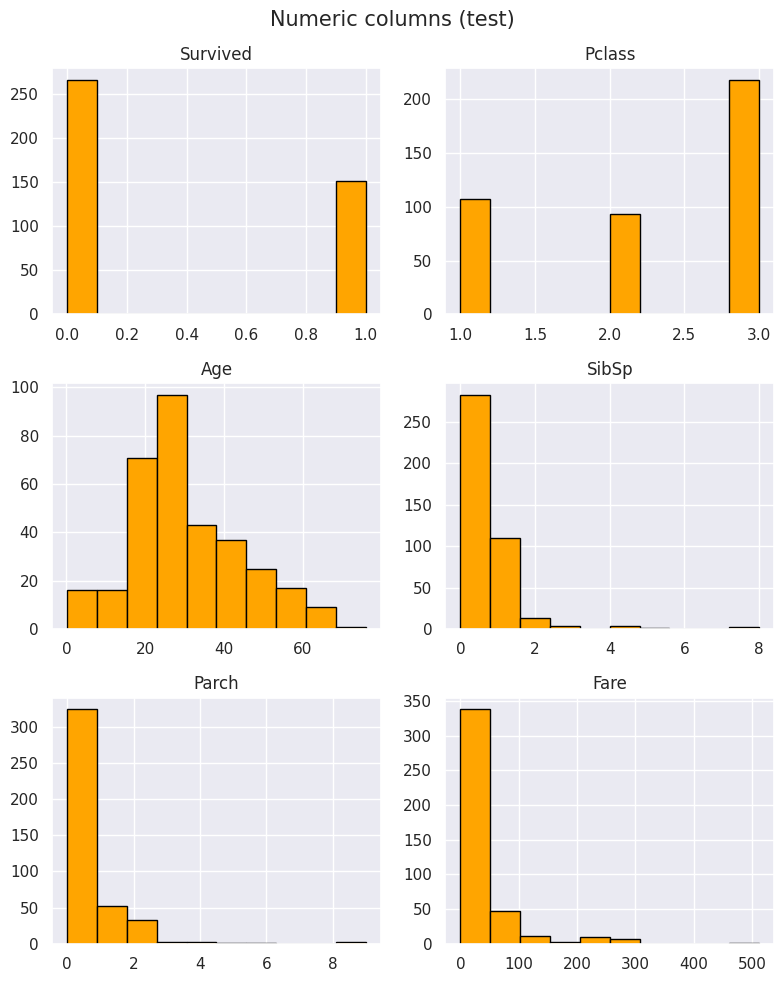

In [107]:
# Plotting histograms for the test data
cols_to_display = test_data.columns[1:]
test_data[cols_to_display].hist(
    figsize=(8, 10), color="orange", edgecolor="black"
)
plt.suptitle("Numeric columns (test)", fontsize=15)
plt.tight_layout()
plt.show()

In [108]:
from sklearn.base import BaseEstimator, TransformerMixin

class Eliminator(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xtransformed = X.drop(self.features, axis=1, inplace=False)
        return Xtransformed

eliminated = ['Name', 'Ticket', 'Cabin']
el = Eliminator(eliminated)
el.fit_transform(ds)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,0,3,male,34.5,0,0,7.8292,Q
1,893,1,3,female,47.0,1,0,7.0000,S
2,894,0,2,male,62.0,0,0,9.6875,Q
3,895,0,3,male,27.0,0,0,8.6625,S
4,896,1,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...,...,...
413,1305,0,3,male,NaN,0,0,8.0500,S
414,1306,1,1,female,39.0,0,0,108.9000,C
415,1307,0,3,male,38.5,0,0,7.2500,S
416,1308,0,3,male,NaN,0,0,8.0500,S



Design Custom Transformers¶
Eliminator





Transformer to drop specific columns. Accepts iteratable of strings features to be dropped.

In [109]:
from sklearn.preprocessing import OrdinalEncoder

class Encoder(OrdinalEncoder):
    def __init__(self, cloumns_to_encode):
        self.columns = None
        self.cloumns_to_encode = cloumns_to_encode
        OrdinalEncoder.__init__(self)
    def fit(self, X, y=None):
        self.columns = X.columns
        OrdinalEncoder.fit(self, X[self.cloumns_to_encode], y)
        return self
    def transform(self, X):
        Xtransformed = X.copy()
        encoded_data = OrdinalEncoder.transform(self, X[self.cloumns_to_encode])
        Xtransformed[self.cloumns_to_encode] = encoded_data
        return Xtransformed

en = Encoder(['Sex', 'Embarked'])
en.fit_transform(ds)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",1.0,34.5,0,0,330911,7.8292,NaN,1.0
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",0.0,47.0,1,0,363272,7.0000,NaN,2.0
2,894,0,2,"Myles, Mr. Thomas Francis",1.0,62.0,0,0,240276,9.6875,NaN,1.0
3,895,0,3,"Wirz, Mr. Albert",1.0,27.0,0,0,315154,8.6625,NaN,2.0
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0.0,22.0,1,1,3101298,12.2875,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,3,"Spector, Mr. Woolf",1.0,NaN,0,0,A.5. 3236,8.0500,NaN,2.0
414,1306,1,1,"Oliva y Ocana, Dona. Fermina",0.0,39.0,0,0,PC 17758,108.9000,C105,0.0
415,1307,0,3,"Saether, Mr. Simon Sivertsen",1.0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,2.0
416,1308,0,3,"Ware, Mr. Frederick",1.0,NaN,0,0,359309,8.0500,NaN,2.0


Design Custom Transformers
Eliminator



Transformer to drop specific columns. Accepts iteratable of strings features to be dropped.

In [110]:
from sklearn.base import BaseEstimator, TransformerMixin

class Eliminator(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xtransformed = X.drop(self.features, axis=1, inplace=False)
        return Xtransformed

eliminated = ['Name', 'Ticket', 'Cabin']
el = Eliminator(eliminated)
el.fit_transform(ds)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,0,3,male,34.5,0,0,7.8292,Q
1,893,1,3,female,47.0,1,0,7.0000,S
2,894,0,2,male,62.0,0,0,9.6875,Q
3,895,0,3,male,27.0,0,0,8.6625,S
4,896,1,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...,...,...
413,1305,0,3,male,NaN,0,0,8.0500,S
414,1306,1,1,female,39.0,0,0,108.9000,C
415,1307,0,3,male,38.5,0,0,7.2500,S
416,1308,0,3,male,NaN,0,0,8.0500,S



Encoder¶




Transformer to encode data to numerical discerete values of specific columns inheriting OrdinalEncoder utility. Accepts iteratable of strings cloumns_to_encode to be encoded.

In [111]:
from sklearn.preprocessing import OrdinalEncoder

class Encoder(OrdinalEncoder):
    def __init__(self, cloumns_to_encode):
        self.columns = None
        self.cloumns_to_encode = cloumns_to_encode
        OrdinalEncoder.__init__(self)
    def fit(self, X, y=None):
        self.columns = X.columns
        OrdinalEncoder.fit(self, X[self.cloumns_to_encode], y)
        return self
    def transform(self, X):
        Xtransformed = X.copy()
        encoded_data = OrdinalEncoder.transform(self, X[self.cloumns_to_encode])
        Xtransformed[self.cloumns_to_encode] = encoded_data
        return Xtransformed

en = Encoder(['Sex', 'Embarked'])
en.fit_transform(ds)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",1.0,34.5,0,0,330911,7.8292,NaN,1.0
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",0.0,47.0,1,0,363272,7.0000,NaN,2.0
2,894,0,2,"Myles, Mr. Thomas Francis",1.0,62.0,0,0,240276,9.6875,NaN,1.0
3,895,0,3,"Wirz, Mr. Albert",1.0,27.0,0,0,315154,8.6625,NaN,2.0
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0.0,22.0,1,1,3101298,12.2875,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,3,"Spector, Mr. Woolf",1.0,NaN,0,0,A.5. 3236,8.0500,NaN,2.0
414,1306,1,1,"Oliva y Ocana, Dona. Fermina",0.0,39.0,0,0,PC 17758,108.9000,C105,0.0
415,1307,0,3,"Saether, Mr. Simon Sivertsen",1.0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,2.0
416,1308,0,3,"Ware, Mr. Frederick",1.0,NaN,0,0,359309,8.0500,NaN,2.0


In [112]:
def print_inf_and_nan_columns(dataframe):
    notfound = True
    for col in dataframe.columns:
        inf_count = np.isinf(dataframe[col]).values.ravel().sum()
        if inf_count != 0:
            notfound = False
            print(f"'{col}' has {inf_count} +/-inf values!")
        nan_count = np.isnan(dataframe[col]).values.ravel().sum()
        if nan_count != 0:
            notfound = False
            print(f"'{col}' has {nan_count} nan values!")
    if notfound:
        print('No column has nan or +/-inf.')

print_inf_and_nan_columns(en.transform(el.transform(ds)))

'Age' has 86 nan values!
'Fare' has 1 nan values!


CustomImputer



Transformer to impute columns data inheriting SimpleImputer utility. CustomImputer does not do anything more than calling SimpleImputer functions and return transformed data as pandas.DataFrame instead of numpy.ndarray.

In [123]:
from sklearn.impute import SimpleImputer

class CustomImputer(SimpleImputer):
    def __init__(self, missing_values=np.nan, strategy='mean'):
        self.columns = None
        SimpleImputer.__init__(self,
                               missing_values=missing_values,
                               strategy=strategy)
    def fit(self, X, y=None):
        self.columns = X.columns
        SimpleImputer.fit(self, X, y)
        return self
    def transform(self, X):
        Xtransformed = X.copy()
        Xtransformed = SimpleImputer.transform(self, Xtransformed)
        return pd.DataFrame(columns=self.columns, data=Xtransformed)

CustomSTDScaler¶


Transformer to impute scale columns data inheriting StandardScaler utility. Like CustomImputer, CustomSTDScaler does not do anything more than calling SimpleImputer functions and return transformed data as pandas.DataFrame instead of numpy.ndarray.

In [124]:
from sklearn.preprocessing import StandardScaler

class CustomSTDScaler(StandardScaler):
    '''
    `StandardScaler` but returns pandas.DataFrame instead of numpy array when transform is invoked.
    '''
    def __init__(self, keep_features):
        self.columns = None
        self.keep_features = keep_features
        StandardScaler.__init__(self)
    def fit(self, X, y=None):
        self.columns = [col for col in X.columns if col not in self.keep_features]
        StandardScaler.fit(self, X[self.columns])
        return self
    def transform(self, X):
        Xtransformed = X.copy()
        Xtransformed[self.columns] = StandardScaler.transform(self, X[self.columns])
        return Xtransformed

Prepare Data with Preparing Pipeline

In [125]:
X, y = ds.drop('Survived', axis=1), ds['Survived']
X

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [126]:
DIV  = Operation(function=(lambda c1, c2 : c1 / c2),                separator='to')
MUL  = Operation(function=(lambda c1, c2 : c1 * c2),                separator='by')
CDIV = Operation(function=(lambda c1, c2 : DIV.function(c1, c2+1)), separator='to')

eliminated        = ['Name', 'Ticket', 'Cabin']
cloumns_to_encode = ['Sex', 'Embarked']
new_features      = (('Pclass', 'Fare', MUL), ('Parch', 'SibSp', CDIV))
keep_features     = ['PassengerId', 'Sex']

In [118]:
from sklearn.pipeline import Pipeline
preparing_pipeline = Pipeline([
    ('eliminator', Eliminator(eliminated)),
    ('encoder', Encoder(cloumns_to_encode)),
    ('synthesis_reactor', SynthesisReactor(params=new_features)),
    ('imputer', CustomImputer(strategy='mean')),
    ('scaler', CustomSTDScaler(keep_features))
])

prepared = preparing_pipeline.fit_transform(X)
prepared

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Pclass_by_Fare,Parch_to_SibSp
0,892.0,0.873482,1.0,0.334993,-0.499470,-0.400248,-0.498407,-0.470915,-0.539684,-0.392671
1,893.0,0.873482,0.0,1.325530,0.616992,-0.400248,-0.513274,0.700767,-0.584347,-0.392671
2,894.0,-0.315819,1.0,2.514175,-0.499470,-0.400248,-0.465088,-0.470915,-0.613523,-0.392671
3,895.0,0.873482,1.0,-0.259330,-0.499470,-0.400248,-0.483466,0.700767,-0.494800,-0.392671
4,896.0,0.873482,0.0,-0.655545,0.616992,0.619896,-0.418471,0.700767,-0.299547,0.426555
...,...,...,...,...,...,...,...,...,...,...
413,1305.0,0.873482,1.0,0.000000,-0.499470,-0.400248,-0.494448,0.700767,-0.527791,-0.392671
414,1306.0,-1.505120,0.0,0.691586,-0.499470,-0.400248,1.313753,-1.642598,0.993836,-0.392671
415,1307.0,0.873482,1.0,0.651965,-0.499470,-0.400248,-0.508792,0.700767,-0.570882,-0.392671
416,1308.0,0.873482,1.0,0.000000,-0.499470,-0.400248,-0.494448,0.700767,-0.527791,-0.392671


Train and Evaluate Models

In [127]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier()
knn.fit(prepared, y)
preds = knn.predict(prepared)
accuracy_score(y, preds)

0.7296650717703349

In [128]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(prepared, y)
preds_svc = svc.predict(prepared)
accuracy_score(y, preds_svc)

0.6363636363636364

In [129]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(prepared, y)
preds_rfc = rfc.predict(prepared)
accuracy_score(y, preds_rfc)

1.0